In [393]:
import pandas as pd
import numpy as np
import tweepy
import requests
import json
import os
from timeit import default_timer as timer
from tweepy import OAuthHandler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

# Gather

In [394]:
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [395]:
# Use requests library to download tsv file from a website
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)

    


In [396]:
# Read in tsv file as a Pandas DataFrame    
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [397]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [266]:
# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552
Fail
29: 886680336477933568
Fail
30: 886366144734445568
Fail
31: 886267009285017600
Fail
32: 886258384151887873
Fail
33: 886054160059072513
Fail
34: 885984800019947520
Fail
35: 885528943205470208
Fail
36: 885518971528720385
Fail
3

Fail
288: 838561493054533637
Fail
289: 838476387338051585
Fail
290: 838201503651401729
Fail
291: 838150277551247360
Fail
292: 838085839343206401
Fail
293: 838083903487373313
Fail
294: 837820167694528512
Fail
295: 837482249356513284
Fail
296: 837471256429613056
Fail
297: 837366284874571778
Fail
298: 837110210464448512
Fail
299: 837012587749474308
Fail
300: 836989968035819520
Fail
301: 836753516572119041
Fail
302: 836677758902222849
Fail
303: 836648853927522308
Fail
304: 836397794269200385
Fail
305: 836380477523124226
Fail
306: 836260088725786625
Fail
307: 836001077879255040
Fail
308: 835685285446955009
Fail
309: 835574547218894849
Fail
310: 835536468978302976
Fail
311: 835309094223372289
Fail
312: 835297930240217089
Fail
313: 835264098648616962
Fail
314: 835246439529840640
Fail
315: 835172783151792128
Fail
316: 835152434251116546
Fail
317: 834931633769889797
Fail
318: 834786237630337024
Fail
319: 834574053763584002
Fail
320: 834477809192075265
Fail
321: 834458053273591808
Fail
322: 8342

Fail
571: 801854953262350336
Fail
572: 801538201127157760
Fail
573: 801285448605831168
Fail
574: 801167903437357056
Fail
575: 801127390143516673
Fail
576: 801115127852503040
Fail
577: 800859414831898624
Fail
578: 800855607700029440
Fail
579: 800751577355128832
Fail
580: 800513324630806528
Fail
581: 800459316964663297
Fail
582: 800443802682937345
Fail
583: 800388270626521089
Fail
584: 800188575492947969
Fail
585: 800141422401830912
Fail
586: 800018252395122689
Fail
587: 799774291445383169
Fail
588: 799757965289017345
Fail
589: 799422933579902976
Fail
590: 799308762079035393
Fail
591: 799297110730567681
Fail
592: 799063482566066176
Fail
593: 798933969379225600
Fail
594: 798925684722855936
Fail
595: 798705661114773508
Fail
596: 798701998996647937
Fail
597: 798697898615730177
Fail
598: 798694562394996736
Fail
599: 798686750113755136
Fail
600: 798682547630837760
Fail
601: 798673117451325440
Fail
602: 798665375516884993
Fail
603: 798644042770751489
Fail
604: 798628517273620480
Fail
605: 7985

Fail
855: 765222098633691136
Fail
856: 764857477905154048
Fail
857: 764259802650378240
Fail
858: 763956972077010945
Fail
859: 763837565564780549
Fail
860: 763183847194451968
Fail
861: 763167063695355904
Fail
862: 763103485927849985
Fail
863: 762699858130116608
Fail
864: 762471784394268675
Fail
865: 762464539388485633
Fail
866: 762316489655476224
Fail
867: 762035686371364864
Fail
868: 761976711479193600
Fail
869: 761750502866649088
Fail
870: 761745352076779520
Fail
871: 761672994376806400
Fail
872: 761599872357261312
Fail
873: 761371037149827077
Fail
874: 761334018830917632
Fail
875: 761292947749015552
Fail
876: 761227390836215808
Fail
877: 761004547850530816
Fail
878: 760893934457552897
Fail
879: 760656994973933572
Fail
880: 760641137271070720
Fail
881: 760539183865880579
Fail
882: 760521673607086080
Fail
883: 760290219849637889
Fail
884: 760252756032651264
Fail
885: 760190180481531904
Fail
886: 760153949710192640
Fail
887: 759943073749200896
Fail
888: 759923798737051648
Fail
889: 7598

Fail
1133: 728760639972315136
Fail
1134: 728751179681943552
Fail
1135: 728653952833728512
Fail
1136: 728409960103686147
Fail
1137: 728387165835677696
Fail
1138: 728046963732717569
Fail
1139: 728035342121635841
Fail
1140: 728015554473250816
Fail
1141: 727685679342333952
Fail
1142: 727644517743104000
Fail
1143: 727524757080539137
Fail
1144: 727314416056803329
Fail
1145: 727286334147182592
Fail
1146: 727175381690781696
Fail
1147: 727155742655025152
Fail
1148: 726935089318363137
Fail
1149: 726887082820554753
Fail
1150: 726828223124897792
Fail
1151: 726224900189511680
Fail
1152: 725842289046749185
Fail
1153: 725786712245440512
Fail
1154: 725729321944506368
Fail
1155: 725458796924002305
Fail
1156: 724983749226668032
Fail
1157: 724771698126512129
Fail
1158: 724405726123311104
Fail
1159: 724049859469295616
Fail
1160: 724046343203856385
Fail
1161: 724004602748780546
Fail
1162: 723912936180330496
Fail
1163: 723688335806480385
Fail
1164: 723673163800948736
Fail
1165: 723179728551723008
Fail
1166:

Fail
1408: 699079609774645248
Fail
1409: 699072405256409088
Fail
1410: 699060279947165696
Fail
1411: 699036661657767936
Fail
1412: 698989035503689728
Fail
1413: 698953797952008193
Fail
1414: 698907974262222848
Fail
1415: 698710712454139905
Fail
1416: 698703483621523456
Fail
1417: 698635131305795584
Fail
1418: 698549713696649216
Fail
1419: 698355670425473025
Fail
1420: 698342080612007937
Fail
1421: 698262614669991936
Fail
1422: 698195409219559425
Fail
1423: 698178924120031232
Fail
1424: 697995514407682048
Fail
1425: 697990423684476929
Fail
1426: 697943111201378304
Fail
1427: 697881462549430272
Fail
1428: 697630435728322560
Fail
1429: 697616773278015490
Fail
1430: 697596423848730625
Fail
1431: 697575480820686848
Fail
1432: 697516214579523584
Fail
1433: 697482927769255936
Fail
1434: 697463031882764288
Fail
1435: 697270446429966336
Fail
1436: 697259378236399616
Fail
1437: 697255105972801536
Fail
1438: 697242256848379904
Fail
1439: 696900204696625153
Fail
1440: 696894894812565505
Fail
1441:

Fail
1683: 681891461017812993
Fail
1684: 681694085539872773
Fail
1685: 681679526984871937
Fail
1686: 681654059175129088
Fail
1687: 681610798867845120
Fail
1688: 681579835668455424
Fail
1689: 681523177663676416
Fail
1690: 681340665377193984
Fail
1691: 681339448655802368
Fail
1692: 681320187870711809
Fail
1693: 681302363064414209
Fail
1694: 681297372102656000
Fail
1695: 681281657291280384
Fail
1696: 681261549936340994
Fail
1697: 681242418453299201
Fail
1698: 681231109724700672
Fail
1699: 681193455364796417
Fail
1700: 680970795137544192
Fail
1701: 680959110691590145
Fail
1702: 680940246314430465
Fail
1703: 680934982542561280
Fail
1704: 680913438424612864
Fail
1705: 680889648562991104
Fail
1706: 680836378243002368
Fail
1707: 680805554198020098
Fail
1708: 680801747103793152
Fail
1709: 680798457301471234
Fail
1710: 680609293079592961
Fail
1711: 680583894916304897
Fail
1712: 680497766108381184
Fail
1713: 680494726643068929
Fail
1714: 680473011644985345
Fail
1715: 680440374763077632
Fail
1716:

Fail
1957: 673612854080196609
Fail
1958: 673583129559498752
Fail
1959: 673580926094458881
Fail
1960: 673576835670777856
Fail
1961: 673363615379013632
Fail
1962: 673359818736984064
Fail
1963: 673355879178194945
Fail
1964: 673352124999274496
Fail
1965: 673350198937153538
Fail
1966: 673345638550134785
Fail
1967: 673343217010679808
Fail
1968: 673342308415348736
Fail
1969: 673320132811366400
Fail
1970: 673317986296586240
Fail
1971: 673295268553605120
Fail
1972: 673270968295534593
Fail
1973: 673240798075449344
Fail
1974: 673213039743795200
Fail
1975: 673148804208660480
Fail
1976: 672997845381865473
Fail
1977: 672995267319328768
Fail
1978: 672988786805112832
Fail
1979: 672984142909456390
Fail
1980: 672980819271634944
Fail
1981: 672975131468300288
Fail
1982: 672970152493887488
Fail
1983: 672968025906282496
Fail
1984: 672964561327235073
Fail
1985: 672902681409806336
Fail
1986: 672898206762672129
Fail
1987: 672884426393653248
Fail
1988: 672877615439593473
Fail
1989: 672834301050937345
Fail
1990:

Fail
2231: 668237644992782336
Fail
2232: 668226093875376128
Fail
2233: 668221241640230912
Fail
2234: 668204964695683073
Fail
2235: 668190681446379520
Fail
2236: 668171859951755264
Fail
2237: 668154635664932864
Fail
2238: 668142349051129856
Fail
2239: 668113020489474048
Fail
2240: 667937095915278337
Fail
2241: 667924896115245057
Fail
2242: 667915453470232577
Fail
2243: 667911425562669056
Fail
2244: 667902449697558528
Fail
2245: 667886921285246976
Fail
2246: 667885044254572545
Fail
2247: 667878741721415682
Fail
2248: 667873844930215936
Fail
2249: 667866724293877760
Fail
2250: 667861340749471744
Fail
2251: 667832474953625600
Fail
2252: 667806454573760512
Fail
2253: 667801013445750784
Fail
2254: 667793409583771648
Fail
2255: 667782464991965184
Fail
2256: 667773195014021121
Fail
2257: 667766675769573376
Fail
2258: 667728196545200128
Fail
2259: 667724302356258817
Fail
2260: 667550904950915073
Fail
2261: 667550882905632768
Fail
2262: 667549055577362432
Fail
2263: 667546741521195010
Fail
2264:

In [398]:
tweets_df = []

with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweets_df.append(json.loads(line))

In [399]:
data_ = []

for twt in tweets_df:
    
    tweet_id = twt['id']
    retweetcount = twt['retweet_count']
    favoritecount = twt['favorite_count']
    
    
    data_.append({'id':tweet_id,
                  
                  'favorites': favoritecount,
                  
                  'retweet': retweetcount
                  
                  })
    
data_tweets_api = pd.DataFrame(data_, columns=['id', 'favorites', 'retweet'])

In [400]:
data_tweets_api.head()

,id,favorites,retweet
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


# Assessment


#we have three dataframes


1-image_predictions has the results of a neural network trying to identify dog breed in a tweet's picture.

2-twitter_archive_df has the tweet's text, rating, and dog category.

3-data_tweets_api which has id, retweet and favorite counts


In [401]:
twitter_archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [402]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [403]:
data_tweets_api.head()

,id,favorites,retweet
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


In [404]:
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [405]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [406]:
data_tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id           2354 non-null int64
favorites    2354 non-null int64
retweet      2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


## Quality Issues
1-Remove all retweets from the base
2-in twitter_archive_df: Missing dog names.
3-in twitter_archive_df:incorrect dog names.
4-Contents of 'text' cutoff.
5-tweet_id is int.
6- Timestamp column is a string.
7-in_reply_to_status_id is float.
8-in_reply_to_user_id is float.
9-rating_numerator is int.
10-rating_denominator is int.
11-Delete (url) from source column.
12-remove all non-dog breeds (false).



## Tidiness
1-Rename the columns of image prediction to more descriptive names
2-group the nine colmns( p1 	p1_conf 	p2_dog, p2 	p2_conf 	p2_dog, p3 	p3_conf 	p3_dog)into three columns.
3-Four columns for stages of dog (doggo, pupper, puppo, floofer) should be one category column.
4-Move favourtes and retweet columns from (data_tweets_api_clean) to (twitter_archive_df_clean)
5-Move jpg_url column from (image_predictions_clean) to (twitter_archive_df_clean).  .




# cleaning

# quality


In [407]:
#creat copies from orginal dataframs
twitter_archive_df_clean = twitter_archive_df.copy()
image_predictions_clean = image_predictions.copy()
data_tweets_api_clean = data_tweets_api.copy()



### Define
solve quality issue number (1): Remove all retweet from twitter_archive_df

### Code 

In [408]:
twitter_archive_df_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

### Test

In [409]:
twitter_archive_df_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying in

### Define
solve quality issue number (2,3)  : Missing and incorrect dog names

### Code 

In [410]:
(twitter_archive_df_clean.name == 'None').sum()

745

In [411]:
# list of lowercase dog names 
lower_list = list(twitter_archive_df_clean[twitter_archive_df_clean.name.str.islower()].name.value_counts().index)
lower_list.append('None')
lower_list

['a',
 'the',
 'an',
 'very',
 'quite',
 'one',
 'just',
 'not',
 'actually',
 'getting',
 'mad',
 'such',
 'by',
 'incredibly',
 'life',
 'his',
 'light',
 'infuriating',
 'unacceptable',
 'space',
 'officially',
 'my',
 'this',
 'all',
 'old',
 'None']

In [412]:
twitter_archive_df_clean.name = twitter_archive_df_clean.name.replace(lower_list, np.nan)

In [413]:
twitter_archive_df_clean.name.value_counts()

Charlie       12
Cooper        11
Oliver        11
Lucy          11
Tucker        10
Penny         10
Lola          10
Winston       9 
Bo            9 
Sadie         8 
Buddy         7 
Toby          7 
Bailey        7 
Daisy         7 
Dave          6 
Oscar         6 
Rusty         6 
Milo          6 
Jack          6 
Scout         6 
Leo           6 
Bella         6 
Koda          6 
Stanley       6 
Jax           6 
Alfie         5 
Oakley        5 
Sammy         5 
Bentley       5 
Louis         5 
             .. 
Damon         1 
Molly         1 
Stewie        1 
Bertson       1 
Chaz          1 
General       1 
Terrenth      1 
Jeffrie       1 
Rolf          1 
Akumi         1 
Bookstore     1 
Rudy          1 
Yukon         1 
Cheryl        1 
Chesterson    1 
William       1 
Vixen         1 
Grady         1 
Heinrich      1 
Einstein      1 
Brandonald    1 
Lolo          1 
Zooey         1 
Bert          1 
Glacier       1 
Opie          1 
Brudge        1 
Pilot         

In [414]:
twitter_archive_df_clean = twitter_archive_df_clean.replace(value = np.nan, to_replace = ["None"])

### Test 

In [415]:
twitter_archive_df_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,NaN,NaN,NaN,NaN,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,NaN,NaN,NaN,NaN,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and st

### Define
solve quality issue number (4): Contents of 'text' cutoff

### Code 

In [416]:
pd.set_option('display.max_colwidth', -1)

### Test 

In [417]:
twitter_archive_df_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,NaN,NaN,NaN,NaN,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,NaN,NaN,NaN,NaN,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and st

### Define
solve quality issue number (5):tweet_id is int convert to str

### Code 

In [418]:
twitter_archive_df_clean['tweet_id'] = twitter_archive_df_clean.astype('str')
image_predictions_clean['tweet_id'] = image_predictions_clean.astype('str')
data_tweets_api_clean['id'] = data_tweets_api_clean.astype('str')

### Test 

In [419]:
twitter_archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2356 non-null object
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2356 non-null object
source                   2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null int64
rating_denominator       2356 non-null int64
name                     1502 non-null object
doggo                    97 non-null object
floofer                  10 non-null object
pupper                   257 non-null object
puppo                    30 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 257.8+ KB


In [420]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [421]:
data_tweets_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id           2354 non-null object
favorites    2354 non-null int64
retweet      2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


### Define
solve quality issue number (6):Change the timestamp column to a datetime format.

### Code

In [422]:
twitter_archive_df_clean['timestamp'] = pd.to_datetime(twitter_archive_df_clean['timestamp'])

### Test

In [423]:
twitter_archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2356 non-null object
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2356 non-null datetime64[ns]
source                   2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null int64
rating_denominator       2356 non-null int64
name                     1502 non-null object
doggo                    97 non-null object
floofer                  10 non-null object
pupper                   257 non-null object
puppo                    30 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 257.8+ KB


### Define
solve quality issue number (7):in_reply_to_status_id is float convert it to str

### Code

In [424]:
twitter_archive_df_clean['in_reply_to_status_id'] = twitter_archive_df_clean.astype('str')

### Test

In [425]:
twitter_archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2356 non-null object
in_reply_to_status_id    2356 non-null object
in_reply_to_user_id      78 non-null float64
timestamp                2356 non-null datetime64[ns]
source                   2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null int64
rating_denominator       2356 non-null int64
name                     1502 non-null object
doggo                    97 non-null object
floofer                  10 non-null object
pupper                   257 non-null object
puppo                    30 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(10)
memory usage: 257.8+ KB


### Define
solve quality issue number (8):in_reply_to_user_id is float convert it to str

### Code

In [426]:
twitter_archive_df_clean['in_reply_to_user_id'] = twitter_archive_df_clean.astype('str')

### Test

In [427]:
twitter_archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2356 non-null object
in_reply_to_status_id    2356 non-null object
in_reply_to_user_id      2356 non-null object
timestamp                2356 non-null datetime64[ns]
source                   2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null int64
rating_denominator       2356 non-null int64
name                     1502 non-null object
doggo                    97 non-null object
floofer                  10 non-null object
pupper                   257 non-null object
puppo                    30 non-null object
dtypes: datetime64[ns](1), int64(2), object(11)
memory usage: 257.8+ KB


### Define
solve quality issue number (9,10):rating_numerator and rating_denominator is int convert it to float


### Code

In [428]:
twitter_archive_df_clean['rating_numerator'] = twitter_archive_df_clean['rating_numerator'].astype('float')

In [429]:
twitter_archive_df_clean['rating_denominator'] = twitter_archive_df_clean['rating_denominator'].astype('float')

### Test

In [430]:
twitter_archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2356 non-null object
in_reply_to_status_id    2356 non-null object
in_reply_to_user_id      2356 non-null object
timestamp                2356 non-null datetime64[ns]
source                   2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null float64
rating_denominator       2356 non-null float64
name                     1502 non-null object
doggo                    97 non-null object
floofer                  10 non-null object
pupper                   257 non-null object
puppo                    30 non-null object
dtypes: datetime64[ns](1), float64(2), object(11)
memory usage: 257.8+ KB


### Define
solve quality issue number (11): Delete (url) from source column.

### Code

In [431]:
twitter_archive_df_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

In [432]:
mapping = {'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':"iPhone", 
           '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':"Vine",
           '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':"Web Client",
           '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':"TweetDeck"}
twitter_archive_df_clean.source = twitter_archive_df_clean.source.map(mapping)

In [433]:
twitter_archive_df_clean.source = twitter_archive_df_clean.source.astype('category')

### Test

In [434]:
twitter_archive_df_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,892420643555336193,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,892177421306343426,892177421306343426,2017-08-01 00:17:27,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,891815181378084864,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,891689557279858688,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,891327558926688256,891327558926688256,2017-07-29 16:00:24,iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,891087950875897856,891087950875897856,2017-07-29 00:08:17,iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,10.0,NaN,NaN,NaN,NaN,NaN
6,890971913173991426,890971913173991426,890971913173991426,2017-07-28 16:27:12,iPhone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13.0,10.0,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,890729181411237888,890729181411237888,2017-07-28 00:22:40,iPhone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13.0,10.0,NaN,NaN,NaN,NaN,NaN
8,890609185150312448,890609185150312448,890609185150312448,2017-07-27 16:25:51,iPhone,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13.0,10.0,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,890240255349198849,890240255349198849,2017-07-26 15:59:51,iPhone,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14.0,10.0,Cassie,doggo,NaN,NaN,NaN


In [435]:
image_predictions_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


## Tidiness

### Define
solve tidiness issue number (1): Rename the columns of image prediction to more descriptive names
#dog_breed - conf - dog

### Code

In [436]:
image_predictions_clean.columns =['tweet_id', 'jpg_url' , 'img_num' , 'dog_breed1' , 'conf1' ,'dog1', 'dog_breed2' , 'conf2' ,'dog2', 'dog_breed3' , 'conf3' ,'dog3']

### Define
solve tidiness issue number (2):group image prediction outcomes into 3 columns instead of 9

### Code

In [437]:
image_predictions_clean = pd.wide_to_long(image_predictions_clean, stubnames=('dog_breed','conf', 'dog'), i=['tweet_id'], j='result')

### Test

In [438]:
image_predictions_clean

,,img_num,jpg_url,dog_breed,conf,dog
tweet_id,result,,,,,
666020888022790149,1,1,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True
666029285002620928,1,1,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True
666033412701032449,1,1,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True
666044226329800704,1,1,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True
666049248165822465,1,1,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True
666050758794694657,1,1,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,0.651137,True
666051853826850816,1,1,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,box_turtle,0.933012,False
666055525042405380,1,1,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,chow,0.692517,True
666057090499244032,1,1,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,shopping_cart,0.962465,False


### Define
solve quality issue number (12):remove all non-dog breeds (false)

### Code

In [439]:
image_predictions_clean=image_predictions_clean.loc[image_predictions_clean['dog'] == True]

### Test 

In [440]:
image_predictions_clean.sample(5)

,,img_num,jpg_url,dog_breed,conf,dog
tweet_id,result,,,,,
752334515931054080,1,1,https://pbs.twimg.com/ext_tw_video_thumb/752334354492362752/pu/img/uWISPc0YRmhUi9Ju.jpg,Bedlington_terrier,0.399163,True
819004803107983360,1,1,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,standard_poodle,0.351308,True
712085617388212225,3,2,https://pbs.twimg.com/media/CeHWFksXIAAyypp.jpg,Lhasa,0.119663,True
780800785462489090,3,2,https://pbs.twimg.com/media/CtX2Kr9XYAAuxrM.jpg,Pembroke,0.008862,True
678969228704284672,1,1,https://pbs.twimg.com/media/CWwu6OLUkAEo3gq.jpg,Labrador_retriever,0.680251,True


### Define
solve tidiness issue number (3): Four columns for stages of dog (doggo, pupper, puppo, floofer) should be one category column.

### Code 

In [441]:
cols=['doggo', 'floofer', 'pupper', 'puppo']

twitter_archive_df_clean['dog_stage'] = twitter_archive_df_clean[cols].apply(lambda x: ','.join(x.dropna()), axis=1)


twitter_archive_df_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

twitter_archive_df_clean.replace(to_replace=[''], value=np.nan, inplace=True)

### Test

In [442]:
twitter_archive_df_clean['dog_stage'].value_counts()

pupper           245
doggo            83 
puppo            29 
doggo,pupper     12 
floofer          9  
doggo,puppo      1  
doggo,floofer    1  
Name: dog_stage, dtype: int64

### Define
solve tidiness issue number (4,5): move favourtes and retweet columns from data_tweets_api_clean to twitter_archive_df_clean & move jpg_url column from image_predictions_clean to twitter_archive_df_clean.  .


### Code

In [443]:
twitter_archive_df_clean = data_tweets_api_clean.merge(twitter_archive_df_clean, left_on='id', right_on='tweet_id')

In [444]:
twitter_archive_df_clean.drop(columns=['id'], axis=1, inplace=True)

In [445]:
twitter_archive_df_clean = twitter_archive_df_clean.merge(image_predictions_clean[['jpg_url']], left_on='tweet_id', right_on='tweet_id')

### Test

In [446]:
twitter_archive_df_clean

,favorites,retweet,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url
0,33819,6514,892177421306343426,892177421306343426,892177421306343426,2017-08-01 00:17:27,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
1,33819,6514,892177421306343426,892177421306343426,892177421306343426,2017-08-01 00:17:27,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,33819,6514,892177421306343426,892177421306343426,892177421306343426,2017-08-01 00:17:27,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
3,25461,4328,891815181378084864,891815181378084864,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
4,25461,4328,891815181378084864,891815181378084864,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
5,25461,4328,891815181378084864,891815181378084864,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
6,42908,8964,891689557279858688,891689557279858688,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
7,41048,9774,891327558926688256,891327558926688256,891327558926688256,2017-07-29 16:00:24,iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
8,41048,9774,891327558926688256,891327558926688256,891327558926688256,2017-07-29 16:00:24,iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
9,41048,9774,891327558926688256,891327558926688256,891327558926688256,2017-07-29 16:00:24,iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f

# Store

In [447]:
# Store clean DataFrame(s) in a csv file
twitter_archive_df_clean.to_csv("twitter_archive_master.csv", index=False)

# Analysis and Visualization

In [448]:
#Distribution of tweet source
twitter_archive_df_clean.source.value_counts()

iPhone        4504
Web Client    56  
TweetDeck     21  
Vine          0   
Name: source, dtype: int64

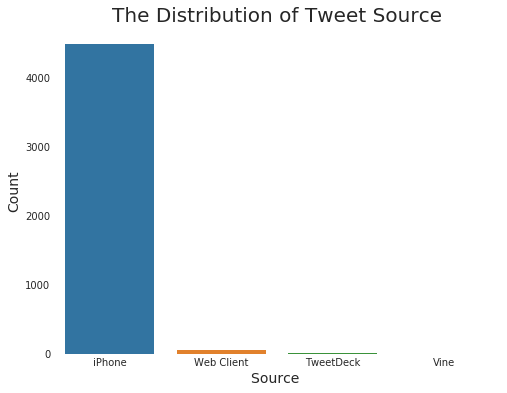

In [455]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sorted_stage = twitter_archive_df_clean.source.value_counts().index[:4]
sns.countplot(data = twitter_archive_df_clean, x = 'source', order=sorted_stage)
plt.xlabel("Source ", fontsize=14)
plt.ylabel("Count",  fontsize=14)
plt.title("The Distribution of Tweet Source", fontsize=20)
for side in ["left", "right", "top", "bottom"]:
    ax.spines[side].set_visible(False)
    


In [450]:
#Distribution of dog_stage
twitter_archive_df_clean.dog_stage.value_counts()

pupper           448
doggo            150
puppo            62 
doggo,pupper     26 
floofer          20 
doggo,puppo      3  
doggo,floofer    3  
Name: dog_stage, dtype: int64

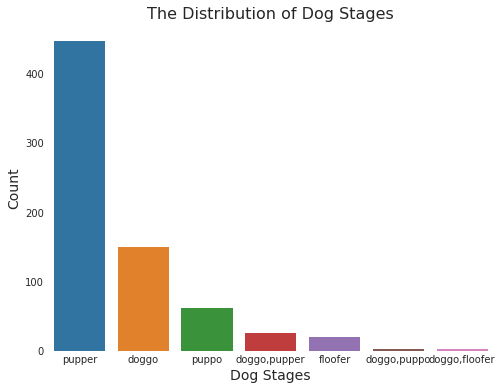

In [451]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sorted_stage = twitter_archive_df_clean.dog_stage.value_counts().index
sns.countplot(data = twitter_archive_df_clean, x = 'dog_stage', order=sorted_stage)

plt.xlabel("Dog Stages", fontsize=14)
plt.ylabel("Count",  fontsize=14)
plt.title("The Distribution of Dog Stages", fontsize=16)

for side in ["left", "right", "top", "bottom"]:
    ax.spines[side].set_visible(False)
    


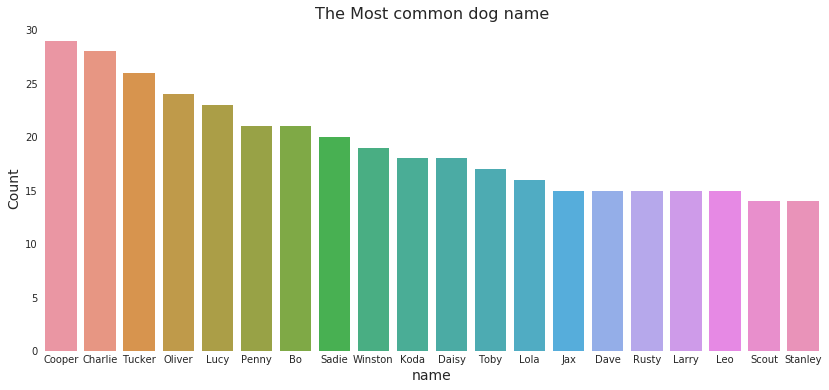

In [452]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
sorted_stage = twitter_archive_df_clean.name.value_counts().head(20).index
sns.countplot(data = twitter_archive_df_clean, x = 'name', order=sorted_stage)

plt.xlabel("name", fontsize=14)
plt.ylabel("Count",  fontsize=14)
plt.title("The Most common dog name", fontsize=16)

for side in ["left", "right", "top", "bottom"]:
    ax.spines[side].set_visible(False)

In [458]:
image_predictions_clean.dog_breed.value_counts()

golden_retriever                  290
Labrador_retriever                283
Chihuahua                         185
Pembroke                          143
Cardigan                          115
Pomeranian                        109
toy_poodle                        105
pug                               97 
chow                              96 
cocker_spaniel                    95 
French_bulldog                    93 
Chesapeake_Bay_retriever          91 
Eskimo_dog                        83 
beagle                            77 
kuvasz                            76 
Siberian_husky                    72 
Staffordshire_bullterrier         70 
Samoyed                           70 
malamute                          69 
Pekinese                          63 
kelpie                            62 
American_Staffordshire_terrier    58 
miniature_pinscher                57 
Great_Pyrenees                    55 
miniature_poodle                  54 
collie                            51 
German_sheph

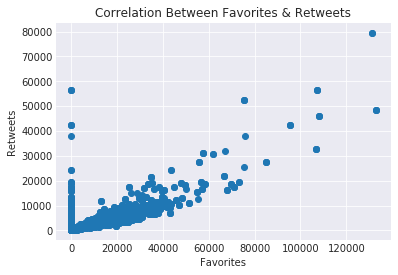

In [459]:
x = twitter_archive_df_clean['favorites']
y = twitter_archive_df_clean['retweet']

plt.scatter(x, y, data = twitter_archive_df_clean,),
plt.title('Correlation Between Favorites & Retweets'),
plt.xlabel('Favorites'),
plt.ylabel('Retweets');

# insights

1-people use twitter on their phone more than on any other devices
2-The most common dog stage is pupper
3-The most common dog name is Charlie
4-The most repeated dog breed is golden_retriever  
